# Backtracking algorithms evaluation report
- Academic Year: 2019/20
- Faculty of Computing - Artificial Intelligence - Semester 2
- Full name and student id: Kacper Trębacz 145453
- Subject: Algorithms and Data Structures


This exercise consinst of two parts:
- evaluation of backtracking algorithm for finding eulerian cycle in a randomly generated graph, which is bound to have one
- evaluation of backtracking algorithm for finding hamiltonian cycle in a randomly generated connected graph

In [1]:
from random import randint,sample, randrange
import sys
import matplotlib.pyplot as plt
import numpy as np
import time 
import math
import random
import string
import pandas as pd
import json
import os
import multiprocessing as mp
import psutil 
sys.setrecursionlimit(10**9)
import itertools
plt.rcParams['figure.figsize'] = (10.0, 6.0)
import resource
resource.setrlimit(resource.RLIMIT_STACK, (resource.RLIM_INFINITY, resource.RLIM_INFINITY))

## Constants declaration

In [2]:
ADJACENCY_MATRIX = "Adjacency Matrix"
INCIDENCE_MATRIX = "Incidence Matrix"
EDGE_LIST = "Edge List"
LIST_OF_INCIDENTS = "List of Incidents"
TIMEOUT = 30
COPIES = 1

In [3]:
def edges_count(n,saturation):
    return int(n*(n-1)*saturation/2)

In [4]:
edge_saturations = [0.2, 0.3, 0.4, 0.6, 0.8, 0.95]

## Graph generation

First we need to generate graphs. THere will be 2 groups. In first of them "hamiltonian" we are going to generate random connected graphs. For the second group "eulerian" we first generate random connected graph, but them we split its edges into 2 groups (those with even and odd degree) and for every 2 vertices with odd degree we either add or delete an edge between them so that the both have even degree. We do remove and delete interchangebly, so in the end the saturation is marginally lower or higher than expected. For graph with more esges its more or less 0.08%. Graphs are stored in text files as adjacency matrixes.

In [5]:
def generate_connected_graph(n,saturation):
    array = np.zeros((n,n), dtype=bool)
    n_edges = edges_count(n,saturation)
    connected_edges = [randrange(0,n)]
    not_connected_edges = [i for i in range(n) if i not in connected_edges]
    random.shuffle(not_connected_edges)
    for i in range(n-1):
        not_connected = not_connected_edges.pop()
        connected = random.choice(connected_edges)
        array[not_connected][connected]=True
        array[connected][not_connected]=True
        connected_edges.append(not_connected)
    for i in range(n_edges-n+1):
        x,y = randrange(n), randrange(n)
        while x==y or array[x][y]:
            x,y = randrange(n), randrange(n)
        array[x][y] = True
        array[y][x] = True
    return array

#functions for checking if graph is connected
def is_connected_ref(node_id, graph, n, visited):
    visited[node_id] = True
    if sum(visited) == len(visited):
        return True
    for i in range(n):
        if graph[node_id][i] and not visited[i]:
            if is_connected_ref(i,graph,n,visited):
                return True
    return False

def is_connected(graph,n):
    visited = [False]*n
    return is_connected_ref(0,graph, n,visited)
    
    
#generating eulerian graph from connected graph
def generate_eulerian(n, saturation):
    graph = generate_connected_graph(n, saturation)
    even_vertices =[]
    odd_vertices =[]
    for i in range(n):
        num_od_edges = np.dot(np.ones(n), graph[i])
        if num_od_edges % 2 == 0:
            even_vertices.append(i)
        else:
            odd_vertices.append(i)
    desired_num_edges = edges_count(n,saturation)
    cur_num_edges = desired_num_edges
    while len(odd_vertices):
        #deletion
        for vert1, vert2 in itertools.combinations(odd_vertices,2):
            if graph[vert1][vert2]:
                graph[vert1][vert2], graph[vert2][vert1] = False, False
                if is_connected(graph, n):
                    cur_num_edges-=1
                    odd_vertices.remove(vert1)
                    odd_vertices.remove(vert2)
                    break
                graph[vert1][vert2], graph[vert2][vert1] = True, True
                if len(odd_vertices) == 2:
                    edge = 0
                    while edge == vert1 or edge == vert2 or graph[edge][vert1] or graph[edge][vert2]:
                        edge+=1
                    graph[edge][vert1],graph[edge][vert2],graph[vert1][edge],graph[vert2][edge] = True,True,True,True
                    odd_vertices.remove(vert1)
                    odd_vertices.remove(vert2)
                    break
    
        #addition         
        for vert1, vert2 in itertools.combinations(odd_vertices,2):
                if not graph[vert1][vert2]:
                    cur_num_edges+=1
                    graph[vert1][vert2],graph[vert2][vert1] = True,True
                    odd_vertices.remove(vert1)
                    odd_vertices.remove(vert2)
                    break
    
    return graph
        
            
        

def generate_eulerian_and_write_to_file(min,max,jump,saturations):
    for saturation in saturations:
        print(saturation)
        for i in range(min,max,jump):
                graph = generate_eulerian(i,saturation)
                os.makedirs("data/eulerian/"+str(saturation)+"/"+str(i), exist_ok=True)
                np.savetxt("data/eulerian/"+str(saturation)+"/"+str(i)+"/"+str(0)+".txt", graph, fmt="%5i")


def generate_random_connected_and_write_to_file(min,max,jump,saturations):
    for sat in saturations:
        print(sat)
        for i in range(min,max,jump):
            copy=0
            os.makedirs("data/hamiltonian/"+str(sat)+"/"+str(i), exist_ok= True)
            while(copy<COPIES):
                graph = generate_connected_graph(i,sat)
                np.savetxt("data/hamiltonian/"+str(sat)+"/"+str(i)+"/"+str(copy)+".txt", graph, fmt="%5i")
                copy+=1
                
def read_graph(folder,saturation,n,copy):
    return np.loadtxt("data/"+str(folder)+"/"+str(saturation)+"/"+str(n)+"/"+str(copy)+".txt", dtype=bool)

Now we generate 21x10 (10 is number of different gaph fo each size) random connected graphs with number of edges from 10 to 310. We do it for each edge saturation.

In [6]:
# generate_random_connected_and_write_to_file(10,506,15,edge_saturations)

And we also generate 50 "eulerian" graphs with number of edges from 10 to 500. We do it for each edge saturation

In [7]:
# generate_eulerian_and_write_to_file(10,501,10,edge_saturations)

# Graph convertion

Here we delacre functions which convert graphs from text files to an adjacency list. This is the representation that we are going to use in both experiments. I will justify this choice in other sections.

### List of Incidents

In [8]:
def convert_to_list_of_incidents(n,array):
    incidents_list = []
    for i in range(n):
        incidents = []
        for j in range(n):
            if i !=j and array[i][j] == 1:
                incidents.append(j)
        incidents_list.append(incidents)
    return incidents_list

# Part 1

In this part we are going to evaluate a backtracking algorithm for finding eulerian cycle in graph. My choice here was to use list of incidence representation. The other possibility was adjacency matrix. In my opinion it is as good as adjacency list. They are both faster at different operations. List of incidence iterates faster over edges of each vertex because it doesn't need to check if such a edge exists, but it needs more time to find and "delete" a given edge, while adjacency matrix does it almost immediately. That is why list of incidence is more suitable for graphs with smaller edge saturation and adjacency matrix would perform better in more dense graphs. Due to the fact that we nned to perform tests on both types of graphs I decided to choose adjacency list because it was easier for me to implement and in most cases takes up less memory.

### Backtracking algorithm definition

In [9]:
def eulerian_backtracking(graph, n_vert,n_edges, path, depth):
    global back
    if depth == n_edges:
        final_edge_exists = path[0] in graph[path[depth-1]]
        if final_edge_exists:
            path.append(path[0])
        return final_edge_exists
    for i in range(len(graph[path[depth-1]])):
        v = graph[path[depth-1]][i]
        if v == -1:
            continue
        graph[path[depth-1]][i] = -1
        replace_index = graph[v].index(path[depth-1])
        graph[v][replace_index] = -1
        path.append(v)
        if eulerian_backtracking(graph, n_vert, n_edges, path, depth+1):
            return path
        path.pop()
        graph[path[depth-1]][i] = v
        graph[v][replace_index] = path[depth-1]
    return False

def find_eulerian_cycle(graph,n):
    m=0
    for vlist in graph:
        length = len(vlist)
        if length%2==1:
            return False
        m+=length
    m=int(m/2)
    return eulerian_backtracking(graph,n,m,[0],1)
    

### Time measurement functions definition

We measure each time once for each number of elements with each edge saturation

In [10]:
def measure_eulerian_single(graph,n):
    adj_list = convert_to_list_of_incidents(n,graph)
    startTime = time.time()
    find_eulerian_cycle(adj_list,n)
    return time.time()-startTime

def measure_times_eulerian(saturation,n):
    time = measure_eulerian_single(read_graph("eulerian",saturation,n,0),n)
    return time

In [11]:
def plot_plot(X,Ys,labels,title):
    for i in range(len(Ys)):
        plt.plot(X,Ys[i],label=str(labels[i]))
    plt.legend()
    plt.xlabel('Number of Elements')
    plt.ylabel('Time (s)')
    plt.title(title)
    plt.show()
    plt.close()

def perform_test_single_entry_eulerian(entry, X):
    return [measure_times_eulerian(entry,n) for n in X]

def perform_tests_eulerian(entries,minimum=11,maximum=22,jump=1):
    X = [i for i in range(minimum,maximum, jump)]
    Ys = [perform_test_single_entry_eulerian(entry,X) for entry in entries]
    print(Ys)
    plot_plot(X, Ys, entries, "Eulerian cycle search time")

Here we run the tests

In [12]:
# perform_tests_eulerian(edge_saturations,10,501,10)

Results are very clear we can see that the higher the edge saturation is the longer it takes to find a cycle. Theoretically the time complexity should be extremely high, even 2^(m). Here we do not see it, because algorithm does not need to check every possible path, because the graph is bound to have a cycle, so algorithm does not need to "go back" so much. In fact this number is so small that it is negliegible. (I run one test for graph with 23 000 edges and it needed to "go back" around 300 times before it found a cycle and finished. So here result highly depends on a number of edge, so its complexity when there are n verticies is O(n(n-1)*saturation/2) or O(E). However it worst case complexity is bigger.

# Part 2

In this part we are going to evaluate a backtracking algorithm for finding hamiltonian cycle in graph. Here the choice again is incidence list, but here it is more justified because it this exercise it takes much longer to find a cycle in a graph with lower edge saturation (it can not exist). And in this setting list of incidents is more efficient.

### Algorithm implementation

In [13]:
def backtracking_hamiltonian_adjacency(graph, n_vert, path, depth,startTime):
    if time.time()-startTime >= TIMEOUT:
            raise TimeoutError("timeout :(")
    if depth == n_vert:
        return path[0] in graph[path[depth-1]]
    for v in graph[path[depth-1]]:
        if (v not in path):
            path.append(v)
            if backtracking_hamiltonian_adjacency(graph,n_vert,path,depth+1,startTime):
                return path
            path.pop()
    return False

### Time measurement functions definition

Here we measure time of each of 10 generated graphs for every size and edge saturation and we average them. In order to speed up computation we use multiprocessing library to run this algorithm on all available cors at once. Even in this setting (6 cores) it takes 30 min to complete. Due to the fact that we are not sure if there is a cycle in a graph we stop computation for each graph after 30s seconds if it is not finished.

In [14]:
def measure_single_hamiltonian(graph,n):
        try:
            adj_list = convert_to_list_of_incidents(n,graph)
            startTime = time.time()
            backtracking_hamiltonian_adjacency(adj_list,n,[0],1,startTime)
            return time.time()-startTime
        except TimeoutError:
                print("timeout")
                return TIMEOUT
            
def measure_times_hamiltonian(saturation,n):
    pool = mp.Pool(psutil.cpu_count(logical = False))
    times = pool.starmap(measure_single_hamiltonian,[(read_graph("hamiltonian",saturation,n,copy),n) for copy in range(COPIES)])
    pool.terminate()
    return sum(times)/COPIES

def perform_test_single_entry(entry, X):
    print("Saturation: "+str(entry))
    return [measure_times_hamiltonian(entry,n) for n in X]

def perform_tests(entries,minimum=11,maximum=22,jump=1):
    X = [i for i in range(minimum,maximum, jump)]
    Ys = [perform_test_single_entry(entry,X) for entry in entries]
    print(Ys)
    plot_plot(X, Ys, entries, "Hamiltonian cycle search time")
    plt.yscale("log")
    plot_plot(X, Ys, entries, "Hamiltonian cycle search time log")

And here we run the tests

In [15]:
# perform_tests(edge_saturations,10,312,15)

In [16]:
# perform_tests([0.6,0.8,0.95],10,506,15)

In [17]:
# perform_tests([0.8,0.95],10,506,15)

The results are quite surprising. Theoretically the more edges there are the longer it should take for algorithm to find the cycle, because it needs to check more possibilities. It is the case for the first few experiments for saturation 0.2, but later the results became highly volatile as for the saturations 0.3.However, for saturation 0.3 it takes less time on average, because there is a  gigher changce that there is a hamiltonian cycle in a graph and an algorithm can stop earlier. Although both graphs are extremely volatile we can see a sligh upward trend, which is blocked by a line of 30s, which was our timeout. The graph for saturation 0.6 is also highly unstable, but at its best for more than 400 edges it becomes faster than 0.8 and 0.95, because it has much less edges. Algorithm seems to be the best for saturation 0.8 because there is high chance that the last vertex that we rich has a connection to the first one, but in the worst cases it might take more time than for saturation 0.95. It is hard to determine a time complexity of this algorithm, because it is proportional to the probability that a given path would lead to finding a cycle. From the shape of the graph we could estimate that its is propornialnal to the number of edges for saturation 0.8 and 0.95.

In [18]:
# generate_random_connected_and_write_to_file(100,301,100,[0.2,0.95])

In [19]:
# perform_tests([0.2, 0.95],100, 301, 100 )

[[0.0026209354400634766, 0.023331880569458008, 0.04566693305969238], [0.03335762023925781, 0.24790239334106445, 0.8154041767120361]]


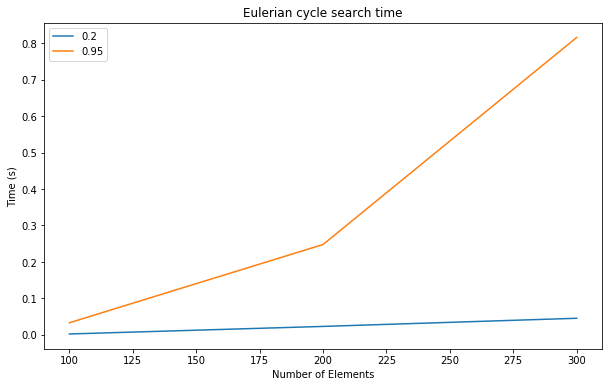

In [22]:
perform_tests_eulerian([0.2,0.95],100, 301,100)